In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]='2'

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split

from torchtext import data, datasets
from torchtext.vocab import Vectors
from torch.nn import init
from torch.autograd import Variable
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
DEVICE

device(type='cuda')

In [3]:
import sys
sys.path.append('/home/bis/2021_SJH_detectability/DbyDeep')
from RefModel.model_CapsNet import *

/home/bis/miniconda3/envs/torch/lib/python3.6/site-packages/torchtext/data/field.py:150: UserWarning: Field class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('{} class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.'.format(self.__class__.__name__), UserWarning)
/home/bis/miniconda3/envs/torch/lib/python3.6/site-packages/torchtext/data/example.py:68: UserWarning: Example class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('Example class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.', UserWarning)
/home/bis/miniconda3/envs/torch/lib/python3.6/site-packages/torchtext/data/example.py:78: UserWarning: Example class will be retired soon and moved to torchtext.legacy. Please se

# 메모
    - GPMDP training dataset은 7.5만개의 펩타이드로 구성, 반반 레이블링
    - DeepMSPeptide, CapsNet 둘다 MOps를 0, LOps를 1로 레이블링해서 학습
    - 추론할때 확률이 높을수록 디텍터블하지 않은 것임
        - DeepMSpeptide의 경우 그래서 1-확률로 바꿔서 표현 (deepMSpeptide공식깃헙 문서에 그렇게 코딩되어있음.)
        - CapsNet도 같은 학습셋을 쓰는데 MOps에 0으로 레이블 된 것 확인함

In [5]:
def tokenizer(text): # create a tokenizer function
    """
    定义分词操作
    """
    return list(text)


LABEL = data.Field(sequential=False, use_vocab=False)
TEXT = data.Field(sequential=True, tokenize=tokenizer ,fix_length=45)
original_train, original_val, original_test = data.TabularDataset.splits(
        path='/home/bis/2021_SJH_detectability/DbyDeep/RefModel/2021MDPI_CapsNet/data/', train='train.csv', validation='train.csv',test='test.csv', format='csv',skip_header=True,
        fields=[('Seqs', TEXT), ('Label', LABEL)])
TEXT.build_vocab(original_train, original_val, original_test)

model = CapsuleNet()
"""
将前面生成的词向量矩阵拷贝到模型的embedding层
这样就自动的可以将输入的word index转为词向量
"""
# 训练
model.to(DEVICE)
# 训练
optimizer = optim.Adam(model.parameters(),lr=0.001)

n_class = 2

model.load_state_dict(torch.load('/home/bis/2021_SJH_detectability/DbyDeep/RefModel/2021MDPI_CapsNet/model/params.pkl'))#, map_location='cpu'))
model.eval()

CapsuleNet(
  (embedding): Embedding(22, 20)
  (lstm): LSTM(20, 40, batch_first=True)
  (conv1): Conv2d(1, 256, kernel_size=(9, 9), stride=(1, 1))
  (conv3): Conv2d(1, 256, kernel_size=(8, 8), stride=(1, 1))
  (cbamBlock): CBAMBlock(
    (avg_pool): AdaptiveAvgPool2d(output_size=1)
    (max_pool): AdaptiveMaxPool2d(output_size=1)
    (channel_excitation): Sequential(
      (0): Linear(in_features=256, out_features=16, bias=False)
      (1): ReLU(inplace=True)
      (2): Linear(in_features=16, out_features=256, bias=False)
    )
    (sigmoid): Sigmoid()
    (spatial_excitation): Sequential(
      (0): Conv2d(2, 1, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), bias=False)
    )
  )
  (conv2): Conv2d(256, 256, kernel_size=(9, 9), stride=(2, 2))
  (conv4): Conv2d(256, 256, kernel_size=(8, 8), stride=(2, 2))
  (capsule): Capsule()
)

In [6]:
df_massive=pd.read_csv('/data/2021_SJH_detectability/data_human/train.csv')
df_hpp=pd.read_csv('/data/2021_SJH_detectability/data_human/HPP.csv')
df_merge=pd.DataFrame(np.concatenate([df_massive.peptide.unique(), df_hpp.peptide.unique()]), columns=['peptide'])
df_merge['Drop']=True

# Cross species - Mouse

/home/bis/miniconda3/envs/torch/lib/python3.6/site-packages/torchtext/data/example.py:68: UserWarning: Example class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('Example class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.', UserWarning)
/home/bis/miniconda3/envs/torch/lib/python3.6/site-packages/torchtext/data/example.py:78: UserWarning: Example class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('Example class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.', UserWarning)
/home/bis/miniconda3/envs/torch/lib/python3.6/site-packages/torchtext/data/iterator.py:48: UserWarning: BucketIterator class will be retired soon and moved to torchtext.legacy. Please see the most recen

TEST Accuracy : 0.1874568751366667
TEST AUC : 0.16649117696759788
              precision    recall  f1-score   support

           0     0.8695    0.1828    0.3021   1245028
           1     0.0145    0.3054    0.0278     49179

    accuracy                         0.1875   1294207
   macro avg     0.4420    0.2441    0.1649   1294207
weighted avg     0.8370    0.1875    0.2917   1294207



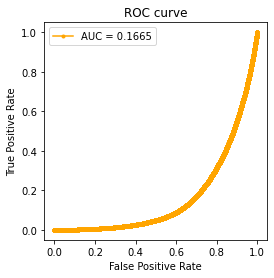

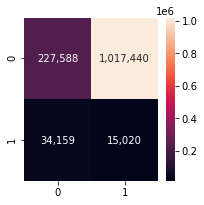

In [7]:
from torchtext import data, datasets

tmp = pd.concat([
    pd.read_csv('/data/2021_SJH_detectability/data_cross_species/raw/mouse/KLife/train.csv'),
    pd.read_csv('/data/2021_SJH_detectability/data_cross_species/raw/mouse/KLife/test.csv'),
])
tmp=tmp.merge(df_merge, how='left')
tmp.Drop.fillna(False, inplace=True)
idxes=tmp.loc[tmp.Drop==True].index
tmp=tmp.drop(idxes, axis=0).reset_index(drop=True)
tmp=tmp.drop(['Drop'],axis=1)
tmp=tmp[['peptide', 'label']]#.drop_duplicates()

tmp = tmp[tmp.peptide.apply(lambda x: 'B' not in x)].reset_index(drop=True)
tmp = tmp[tmp.peptide.apply(lambda x: 'Z' not in x)].reset_index(drop=True)
tmp = tmp.rename({'peptide': 'Seq','label': 'Label'}, axis=1)
tmp['Label'] = tmp.Label.apply(lambda x: {True: 1, False:0}[x])
tmp.to_csv('/home/bis/2021_SJH_detectability/DbyDeep/RefModel/2021MDPI_CapsNet/mouse_KLife_except.csv', index=False)

train1,val1,test1 = data.TabularDataset.splits(
        path='/home/bis/2021_SJH_detectability/DbyDeep/RefModel/2021MDPI_CapsNet/', train='mouse_KLife_except.csv',validation='mouse_KLife_except.csv',test='mouse_KLife_except.csv', format='csv',skip_header=True,
        fields=[('Seqs', TEXT), ('Label', LABEL)])
# TEXT.build_vocab(train1,val1,test1)
test_iter = data.BucketIterator(val1, batch_size=32, sort_key=lambda x: len(x.Seqs), 
                                 shuffle=True,device=DEVICE)

all_pred1 = []
all_true1 = []
all_p1 = []

for batch_idx, batch in enumerate(test_iter):
    data = batch.Seqs
    data = data.permute(1, 0)
    
    out = model(data)
    out = torch.sqrt(torch.sum(out * out, 2))
    out1 = out[:, 1]
    _, y_pre = torch.max(out, -1)
    all_p1.extend(list(out1.cpu().detach().numpy()))
    all_pred1.extend(list(y_pre.cpu().detach().numpy()))
    all_true1.extend(list(batch.Label.cpu().detach().numpy()))

all_pred1 = np.array(list(map(lambda x: x, np.array(all_pred1))))
all_true1 = np.array(all_true1)
all_p1 = np.array(list(map(lambda x: x, np.array(all_p1))))

auc = roc_auc_score(all_true1, all_p1)
acc = metrics.accuracy_score(all_true1,all_pred1)
print('TEST Accuracy : {}'.format(acc))
print('TEST AUC : {}'.format(auc))
print(classification_report(all_true1, all_pred1, digits=4))

plt.figure(figsize=(4, 4))
fpr, tpr, threshold = roc_curve(all_true1, all_p1)
plt.plot(fpr, tpr, marker='.', label='AUC = {:.4f}'.format(auc), color='orange')
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

cf_matrix = confusion_matrix(all_true1, all_pred1)
plt.figure(figsize=(3, 3))
sns.heatmap(cf_matrix, annot=True, fmt=',.0f')
plt.show()

np.save('log/result_mouse_KLife_CapsNet_fpr.npy', fpr)
np.save('log/result_mouse_KLife_CapsNet_tpr.npy', tpr)
np.save('log/result_mouse_KLife_CapsNet_threshold.npy', threshold)
np.save('log/result_mouse_KLife_CapsNet_prob.npy', all_p1)
np.save('log/result_mouse_KLife_CapsNet_true.npy', all_true1)

/home/bis/miniconda3/envs/torch/lib/python3.6/site-packages/torchtext/data/example.py:68: UserWarning: Example class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('Example class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.', UserWarning)
/home/bis/miniconda3/envs/torch/lib/python3.6/site-packages/torchtext/data/example.py:78: UserWarning: Example class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('Example class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.', UserWarning)
/home/bis/miniconda3/envs/torch/lib/python3.6/site-packages/torchtext/data/iterator.py:48: UserWarning: BucketIterator class will be retired soon and moved to torchtext.legacy. Please see the most recen

TEST Accuracy : 0.1940850359270492
TEST AUC : 0.19850517898539388
              precision    recall  f1-score   support

           0     0.8775    0.1866    0.3078   1082017
           1     0.0187    0.3733    0.0357     44989

    accuracy                         0.1941   1127006
   macro avg     0.4481    0.2800    0.1717   1127006
weighted avg     0.8432    0.1941    0.2969   1127006



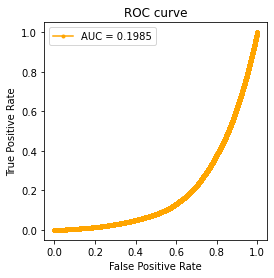

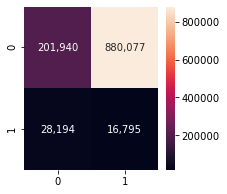

In [8]:
from torchtext import data, datasets

tmp = pd.concat([
    pd.read_csv('/data/2021_SJH_detectability/data_cross_species/raw/mouse/SkeletaMuscle/train.csv'),
    pd.read_csv('/data/2021_SJH_detectability/data_cross_species/raw/mouse/SkeletaMuscle/test.csv'),
])
tmp=tmp.merge(df_merge, how='left')
tmp.Drop.fillna(False, inplace=True)
idxes=tmp.loc[tmp.Drop==True].index
tmp=tmp.drop(idxes, axis=0).reset_index(drop=True)
tmp=tmp.drop(['Drop'],axis=1)
tmp=tmp[['peptide', 'label']]#.drop_duplicates()

tmp = tmp[tmp.peptide.apply(lambda x: 'B' not in x)].reset_index(drop=True)
tmp = tmp[tmp.peptide.apply(lambda x: 'Z' not in x)].reset_index(drop=True)
tmp = tmp.rename({'peptide': 'Seq','label': 'Label'}, axis=1)
tmp['Label'] = tmp.Label.apply(lambda x: {True: 1, False:0}[x])
tmp.to_csv('/home/bis/2021_SJH_detectability/DbyDeep/RefModel/2021MDPI_CapsNet/mouse_SkeletaMuscle_except.csv', index=False)

train1,val1,test1 = data.TabularDataset.splits(
        path='/home/bis/2021_SJH_detectability/DbyDeep/RefModel/2021MDPI_CapsNet/', train='mouse_SkeletaMuscle_except.csv',validation='mouse_SkeletaMuscle_except.csv',test='mouse_SkeletaMuscle_except.csv', format='csv',skip_header=True,
        fields=[('Seqs', TEXT), ('Label', LABEL)])
# TEXT.build_vocab(train1,val1,test1)
test_iter = data.BucketIterator(val1, batch_size=32, sort_key=lambda x: len(x.Seqs), 
                                 shuffle=True,device=DEVICE)

all_pred1 = []
all_true1 = []
all_p1 = []

for batch_idx, batch in enumerate(test_iter):
    data = batch.Seqs
    data = data.permute(1, 0)
    
    out = model(data)
    out = torch.sqrt(torch.sum(out * out, 2))
    out1 = out[:, 1]
    _, y_pre = torch.max(out, -1)
    all_p1.extend(list(out1.cpu().detach().numpy()))
    all_pred1.extend(list(y_pre.cpu().detach().numpy()))
    all_true1.extend(list(batch.Label.cpu().detach().numpy()))
    
all_pred1 = np.array(list(map(lambda x: x, np.array(all_pred1))))
all_true1 = np.array(all_true1)
all_p1 = np.array(list(map(lambda x: x, np.array(all_p1))))
    
auc = roc_auc_score(all_true1, all_p1)
acc = metrics.accuracy_score(all_true1,all_pred1)
print('TEST Accuracy : {}'.format(acc))
print('TEST AUC : {}'.format(auc))
print(classification_report(all_true1, all_pred1, digits=4))



plt.figure(figsize=(4, 4))
fpr, tpr, threshold = roc_curve(all_true1, all_p1)
plt.plot(fpr, tpr, marker='.', label='AUC = {:.4f}'.format(auc), color='orange')
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

cf_matrix = confusion_matrix(all_true1, all_pred1)
plt.figure(figsize=(3, 3))
sns.heatmap(cf_matrix, annot=True, fmt=',.0f')
plt.show()

np.save('log/result_mouse_SkeletaMuscle_CapsNet_fpr.npy', fpr)
np.save('log/result_mouse_SkeletaMuscle_CapsNet_tpr.npy', tpr)
np.save('log/result_mouse_SkeletaMuscle_CapsNet_threshold.npy', threshold)
np.save('log/result_mouse_SkeletaMuscle_CapsNet_prob.npy', all_p1)
np.save('log/result_mouse_SkeletaMuscle_CapsNet_true.npy', all_true1)

# Cross species - Human

/home/bis/miniconda3/envs/torch/lib/python3.6/site-packages/torchtext/data/example.py:68: UserWarning: Example class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('Example class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.', UserWarning)
/home/bis/miniconda3/envs/torch/lib/python3.6/site-packages/torchtext/data/example.py:78: UserWarning: Example class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('Example class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.', UserWarning)
/home/bis/miniconda3/envs/torch/lib/python3.6/site-packages/torchtext/data/iterator.py:48: UserWarning: BucketIterator class will be retired soon and moved to torchtext.legacy. Please see the most recen

TEST Accuracy : 0.17267626173643957
TEST AUC : 0.19582603118370603
              precision    recall  f1-score   support

           0     0.8911    0.1644    0.2776   1353817
           1     0.0167    0.4137    0.0321     46416

    accuracy                         0.1727   1400233
   macro avg     0.4539    0.2890    0.1548   1400233
weighted avg     0.8621    0.1727    0.2695   1400233



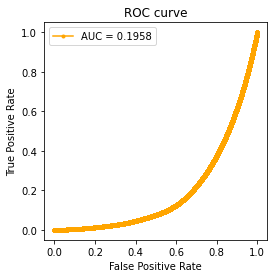

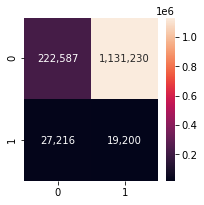

In [9]:
from torchtext import data, datasets

tmp = pd.concat([
    pd.read_csv('/data/2021_SJH_detectability/data_cross_species/raw/human/HEK293/train.csv'),
    pd.read_csv('/data/2021_SJH_detectability/data_cross_species/raw/human/HEK293/test.csv'),
])
tmp=tmp.merge(df_merge, how='left')
tmp.Drop.fillna(False, inplace=True)
idxes=tmp.loc[tmp.Drop==True].index
tmp=tmp.drop(idxes, axis=0).reset_index(drop=True)
tmp=tmp.drop(['Drop'],axis=1)
tmp=tmp[['peptide', 'label']]#.drop_duplicates()

tmp = tmp[tmp.peptide.apply(lambda x: 'B' not in x)].reset_index(drop=True)
tmp = tmp[tmp.peptide.apply(lambda x: 'Z' not in x)].reset_index(drop=True)
tmp = tmp.rename({'peptide': 'Seq','label': 'Label'}, axis=1)
tmp['Label'] = tmp.Label.apply(lambda x: {True: 1, False:0}[x])
tmp.to_csv('/home/bis/2021_SJH_detectability/DbyDeep/RefModel/2021MDPI_CapsNet/human_HEK293_except.csv', index=False)

train1,val1,test1 = data.TabularDataset.splits(
        path='/home/bis/2021_SJH_detectability/DbyDeep/RefModel/2021MDPI_CapsNet/', train='human_HEK293_except.csv',validation='human_HEK293_except.csv',test='human_HEK293_except.csv', format='csv',skip_header=True,
        fields=[('Seqs', TEXT), ('Label', LABEL)])
# TEXT.build_vocab(train1,val1,test1)
test_iter = data.BucketIterator(val1, batch_size=32, sort_key=lambda x: len(x.Seqs), 
                                 shuffle=True,device=DEVICE)

all_pred1 = []
all_true1 = []
all_p1 = []

for batch_idx, batch in enumerate(test_iter):
    data = batch.Seqs
    data = data.permute(1, 0)
    
    out = model(data)
    out = torch.sqrt(torch.sum(out * out, 2))
    out1 = out[:, 1]
    _, y_pre = torch.max(out, -1)
    all_p1.extend(list(out1.cpu().detach().numpy()))
    all_pred1.extend(list(y_pre.cpu().detach().numpy()))
    all_true1.extend(list(batch.Label.cpu().detach().numpy()))

all_pred1 = np.array(list(map(lambda x: x, np.array(all_pred1))))
all_true1 = np.array(all_true1)
all_p1 = np.array(list(map(lambda x: x, np.array(all_p1))))

auc = roc_auc_score(all_true1, all_p1)
acc = metrics.accuracy_score(all_true1,all_pred1)
print('TEST Accuracy : {}'.format(acc))
print('TEST AUC : {}'.format(auc))
print(classification_report(all_true1, all_pred1, digits=4))


plt.figure(figsize=(4, 4))
fpr, tpr, threshold = roc_curve(all_true1, all_p1)
plt.plot(fpr, tpr, marker='.', label='AUC = {:.4f}'.format(auc), color='orange')
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

cf_matrix = confusion_matrix(all_true1, all_pred1)
plt.figure(figsize=(3, 3))
sns.heatmap(cf_matrix, annot=True, fmt=',.0f')
plt.show()

np.save('log/result_human_HEK293_CapsNet_fpr.npy', fpr)
np.save('log/result_human_HEK293_CapsNet_tpr.npy', tpr)
np.save('log/result_human_HEK293_CapsNet_threshold.npy', threshold)
np.save('log/result_human_HEK293_CapsNet_prob.npy', all_p1)
np.save('log/result_human_HEK293_CapsNet_true.npy', all_true1)

In [10]:
from torchtext import data, datasets

tmp = pd.concat([
    pd.read_csv('/data/2021_SJH_detectability/data_cross_species/raw/human/HmapLiver/train.csv'),
    pd.read_csv('/data/2021_SJH_detectability/data_cross_species/raw/human/HmapLiver/test.csv'),
])
tmp=tmp.merge(df_merge, how='left')
tmp.Drop.fillna(False, inplace=True)
idxes=tmp.loc[tmp.Drop==True].index
tmp=tmp.drop(idxes, axis=0).reset_index(drop=True)
tmp=tmp.drop(['Drop'],axis=1)
tmp=tmp[['peptide', 'label']]#.drop_duplicates()

tmp = tmp[tmp.peptide.apply(lambda x: 'B' not in x)].reset_index(drop=True)
tmp = tmp[tmp.peptide.apply(lambda x: 'Z' not in x)].reset_index(drop=True)
tmp = tmp.rename({'peptide': 'Seq','label': 'Label'}, axis=1)
tmp['Label'] = tmp.Label.apply(lambda x: {True: 1, False:0}[x])
tmp.to_csv('/home/bis/2021_SJH_detectability/DbyDeep/RefModel/2021MDPI_CapsNet/human_HmapLiver_except.csv', index=False)

train1,val1,test1 = data.TabularDataset.splits(
        path='/home/bis/2021_SJH_detectability/DbyDeep/RefModel/2021MDPI_CapsNet/', train='human_HmapLiver_except.csv',validation='human_HmapLiver_except.csv',test='human_HmapLiver_except.csv', format='csv',skip_header=True,
        fields=[('Seqs', TEXT), ('Label', LABEL)])
# TEXT.build_vocab(train1,val1,test1)
test_iter = data.BucketIterator(val1, batch_size=32, sort_key=lambda x: len(x.Seqs), 
                                 shuffle=True,device=DEVICE)

all_pred1 = []
all_true1 = []
all_p1 = []

for batch_idx, batch in enumerate(test_iter):
    data = batch.Seqs
    data = data.permute(1, 0)
    
    out = model(data)
    out = torch.sqrt(torch.sum(out * out, 2))
    out1 = out[:, 1]
    _, y_pre = torch.max(out, -1)
    all_p1.extend(list(out1.cpu().detach().numpy()))
    all_pred1.extend(list(y_pre.cpu().detach().numpy()))
    all_true1.extend(list(batch.Label.cpu().detach().numpy()))
    
all_pred1 = np.array(list(map(lambda x: x, np.array(all_pred1))))
all_true1 = np.array(all_true1)
all_p1 = np.array(list(map(lambda x: x, np.array(all_p1))))

auc = roc_auc_score(all_true1, all_p1)
acc = metrics.accuracy_score(all_true1,all_pred1)
print('TEST Accuracy : {}'.format(acc))
print('TEST AUC : {}'.format(auc))
print(classification_report(all_true1, all_pred1, digits=4))


plt.figure(figsize=(4, 4))
fpr, tpr, threshold = roc_curve(all_true1, all_p1)
plt.plot(fpr, tpr, marker='.', label='AUC = {:.4f}'.format(auc), color='orange')
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

cf_matrix = confusion_matrix(all_true1, all_pred1)
plt.figure(figsize=(3, 3))
sns.heatmap(cf_matrix, annot=True, fmt=',.0f')
plt.show()

np.save('log/result_human_HmapLiver_CapsNet_fpr.npy', fpr)
np.save('log/result_human_HmapLiver_CapsNet_tpr.npy', tpr)
np.save('log/result_human_HmapLiver_CapsNet_threshold.npy', threshold)
np.save('log/result_human_HmapLiver_CapsNet_prob.npy', all_p1)
np.save('log/result_human_HmapLiver_CapsNet_true.npy', all_true1)

/home/bis/miniconda3/envs/torch/lib/python3.6/site-packages/torchtext/data/example.py:68: UserWarning: Example class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('Example class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.', UserWarning)
/home/bis/miniconda3/envs/torch/lib/python3.6/site-packages/torchtext/data/example.py:78: UserWarning: Example class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('Example class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.', UserWarning)
/home/bis/miniconda3/envs/torch/lib/python3.6/site-packages/torchtext/data/iterator.py:48: UserWarning: BucketIterator class will be retired soon and moved to torchtext.legacy. Please see the most recen

KeyboardInterrupt: 

# Cross species - Yeast

In [ ]:
from torchtext import data, datasets

tmp = pd.concat([
    pd.read_csv('/data/2021_SJH_detectability/data_cross_species/raw/yeast/DelPBP1/train.csv'),
    pd.read_csv('/data/2021_SJH_detectability/data_cross_species/raw/yeast/DelPBP1/test.csv'),
])
tmp=tmp.merge(df_merge, how='left')
tmp.Drop.fillna(False, inplace=True)
idxes=tmp.loc[tmp.Drop==True].index
tmp=tmp.drop(idxes, axis=0).reset_index(drop=True)
tmp=tmp.drop(['Drop'],axis=1)
tmp=tmp[['peptide', 'label']]#.drop_duplicates()

tmp = tmp[tmp.peptide.apply(lambda x: 'B' not in x)].reset_index(drop=True)
tmp = tmp[tmp.peptide.apply(lambda x: 'Z' not in x)].reset_index(drop=True)
tmp = tmp.rename({'peptide': 'Seq','label': 'Label'}, axis=1)
tmp['Label'] = tmp.Label.apply(lambda x: {True: 1, False:0}[x])
tmp.to_csv('/home/bis/2021_SJH_detectability/DbyDeep/RefModel/2021MDPI_CapsNet/yeast_DelPBP1_except.csv', index=False)

train1,val1,test1 = data.TabularDataset.splits(
        path='/home/bis/2021_SJH_detectability/DbyDeep/RefModel/2021MDPI_CapsNet/', train='yeast_DelPBP1_except.csv',validation='yeast_DelPBP1_except.csv',test='yeast_DelPBP1_except.csv', format='csv',skip_header=True,
        fields=[('Seqs', TEXT), ('Label', LABEL)])
# TEXT.build_vocab(train1,val1,test1)
test_iter = data.BucketIterator(val1, batch_size=32, sort_key=lambda x: len(x.Seqs), 
                                 shuffle=True,device=DEVICE)

all_pred1 = []
all_true1 = []
all_p1 = []

for batch_idx, batch in enumerate(test_iter):
    data = batch.Seqs
    data = data.permute(1, 0)
    
    out = model(data)
    out = torch.sqrt(torch.sum(out * out, 2))
    out1 = out[:, 1]
    _, y_pre = torch.max(out, -1)
    all_p1.extend(list(out1.cpu().detach().numpy()))
    all_pred1.extend(list(y_pre.cpu().detach().numpy()))
    all_true1.extend(list(batch.Label.cpu().detach().numpy()))
    
all_pred1 = np.array(list(map(lambda x: x, np.array(all_pred1))))
all_true1 = np.array(all_true1)
all_p1 = np.array(list(map(lambda x: x, np.array(all_p1))))

auc = roc_auc_score(all_true1, all_p1)
acc = metrics.accuracy_score(all_true1,all_pred1)
print('TEST Accuracy : {}'.format(acc))
print('TEST AUC : {}'.format(auc))
print(classification_report(all_true1, all_pred1, digits=4))


plt.figure(figsize=(4, 4))
fpr, tpr, threshold = roc_curve(all_true1, all_p1)
plt.plot(fpr, tpr, marker='.', label='AUC = {:.4f}'.format(auc), color='orange')
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

cf_matrix = confusion_matrix(all_true1, all_pred1)
plt.figure(figsize=(3, 3))
sns.heatmap(cf_matrix, annot=True, fmt=',.0f')
plt.show()

np.save('log/result_yeast_DelPBP1_CapsNet_fpr.npy', fpr)
np.save('log/result_yeast_DelPBP1_CapsNet_tpr.npy', tpr)
np.save('log/result_yeast_DelPBP1_CapsNet_threshold.npy', threshold)
np.save('log/result_yeast_DelPBP1_CapsNet_prob.npy', all_p1)
np.save('log/result_yeast_DelPBP1_CapsNet_true.npy', all_true1)

In [ ]:
from torchtext import data, datasets

tmp = pd.concat([
    pd.read_csv('/data/2021_SJH_detectability/data_cross_species/raw/yeast/KLife/train.csv'),
    pd.read_csv('/data/2021_SJH_detectability/data_cross_species/raw/yeast/KLife/test.csv'),
])
tmp=tmp.merge(df_merge, how='left')
tmp.Drop.fillna(False, inplace=True)
idxes=tmp.loc[tmp.Drop==True].index
tmp=tmp.drop(idxes, axis=0).reset_index(drop=True)
tmp=tmp.drop(['Drop'],axis=1)
tmp=tmp[['peptide', 'label']]#.drop_duplicates()

tmp = tmp[tmp.peptide.apply(lambda x: 'B' not in x)].reset_index(drop=True)
tmp = tmp[tmp.peptide.apply(lambda x: 'Z' not in x)].reset_index(drop=True)
tmp = tmp.rename({'peptide': 'Seq','label': 'Label'}, axis=1)
tmp['Label'] = tmp.Label.apply(lambda x: {True: 1, False:0}[x])
tmp.to_csv('/home/bis/2021_SJH_detectability/DbyDeep/RefModel/2021MDPI_CapsNet/yeast_KLife_except.csv', index=False)

train1,val1,test1 = data.TabularDataset.splits(
        path='/home/bis/2021_SJH_detectability/DbyDeep/RefModel/2021MDPI_CapsNet/', train='yeast_KLife_except.csv',validation='yeast_KLife_except.csv',test='yeast_KLife_except.csv', format='csv',skip_header=True,
        fields=[('Seqs', TEXT), ('Label', LABEL)])
# TEXT.build_vocab(train1,val1,test1)
test_iter = data.BucketIterator(val1, batch_size=32, sort_key=lambda x: len(x.Seqs), 
                                 shuffle=True,device=DEVICE)

all_pred1 = []
all_true1 = []
all_p1 = []

for batch_idx, batch in enumerate(test_iter):
    data = batch.Seqs
    data = data.permute(1, 0)
    
    out = model(data)
    out = torch.sqrt(torch.sum(out * out, 2))
    out1 = out[:, 1]
    _, y_pre = torch.max(out, -1)
    all_p1.extend(list(out1.cpu().detach().numpy()))
    all_pred1.extend(list(y_pre.cpu().detach().numpy()))
    all_true1.extend(list(batch.Label.cpu().detach().numpy()))
    
all_pred1 = np.array(list(map(lambda x: x, np.array(all_pred1))))
all_true1 = np.array(all_true1)
all_p1 = np.array(list(map(lambda x: x, np.array(all_p1))))

auc = roc_auc_score(all_true1, all_p1)
acc = metrics.accuracy_score(all_true1,all_pred1)
print('TEST Accuracy : {}'.format(acc))
print('TEST AUC : {}'.format(auc))
print(classification_report(all_true1, all_pred1, digits=4))


plt.figure(figsize=(4, 4))
fpr, tpr, threshold = roc_curve(all_true1, all_p1)
plt.plot(fpr, tpr, marker='.', label='AUC = {:.4f}'.format(auc), color='orange')
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

cf_matrix = confusion_matrix(all_true1, all_pred1)
plt.figure(figsize=(3, 3))
sns.heatmap(cf_matrix, annot=True, fmt=',.0f')
plt.show()

np.save('log/result_yeast_KLife_CapsNet_fpr.npy', fpr)
np.save('log/result_yeast_KLife_CapsNet_tpr.npy', tpr)
np.save('log/result_yeast_KLife_CapsNet_threshold.npy', threshold)
np.save('log/result_yeast_KLife_CapsNet_prob.npy', all_p1)
np.save('log/result_yeast_KLife_CapsNet_true.npy', all_true1)